In [2]:
# Import required libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime
#from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pypfopt import EfficientFrontier, risk_models, expected_returns

from pypfopt.discrete_allocation import DiscreteAllocation

import warnings
warnings.filterwarnings('ignore')


In [25]:
tickers = ['TSLA', 'BND', 'SPY']
start_date = '2015-07-01'
end_date = datetime.now().strftime('%Y-%m-%d') 
data1 = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)

[*********************100%***********************]  3 of 3 completed


In [26]:
statistics_results = data1.describe().T
display(pd.DataFrame(statistics_results))

count          mean           std           min  \
Price     Ticker                                                     
Adj Close BND     2542.0  6.848303e+01  4.555963e+00  6.077915e+01   
          SPY     2542.0  3.350103e+02  1.272068e+02  1.558698e+02   
          TSLA    2542.0  1.324654e+02  1.211271e+02  9.578000e+00   
Close     BND     2542.0  7.962815e+01  5.372398e+00  6.804000e+01   
          SPY     2542.0  3.561846e+02  1.189529e+02  1.828600e+02   
          TSLA    2542.0  1.324654e+02  1.211271e+02  9.578000e+00   
High      BND     2542.0  7.974467e+01  5.355847e+00  6.838000e+01   
          SPY     2542.0  3.580845e+02  1.195340e+02  1.841000e+02   
          TSLA    2542.0  1.354673e+02  1.239898e+02  1.033133e+01   
Low       BND     2542.0  7.950886e+01  5.388204e+00  6.799000e+01   
          SPY     2542.0  3.539777e+02  1.182441e+02  1.810200e+02   
          TSLA    2542.0  1.293314e+02  1.182085e+02  9.403333e+00   
Open      BND     2542.0  7.963083e+01  5.375050e+00  6.808000e+01   
          SPY     2542.0  3.561164e+02  1.189286e+02  1.823400e+02   
          TSLA    2542.0  1.324998e+02  1.212406e+02  9.488000e+00   
Volume    BND     2542.0  4.441860e+06  2.900840e+06  0.000000e+00   
          SPY     2542.0  8.503205e+07  4.424822e+07  2.027000e+07   
          TSLA    2542.0  1.140797e+08  7.324707e+07  1.062000e+07   

                           25%           50%           75%           max  
Price     Ticker                                                          
Adj Close BND     6.466343e+01  6.762058e+01  7.190631e+01  7.731824e+01  
          SPY     2.314835e+02  3.055215e+02  4.209094e+02  6.371800e+02  
          TSLA    1.898583e+01  9.871634e+01  2.370600e+02  4.798600e+02  
Close     BND     7.374500e+01  8.100000e+01  8.394000e+01  8.948000e+01  
          SPY     2.587150e+02  3.295200e+02  4.386175e+02  6.371800e+02  
          TSLA    1.898583e+01  9.871634e+01  2.370600e+02  4.798600e+02  
High      BND     7.388250e+01  8.111000e+01  8.406750e+01  8.959000e+01  
          SPY     2.605225e+02  3.316850e+02  4.411350e+02  6.398500e+02  
          TSLA    1.931150e+01  1.007683e+02  2.415775e+02  4.885400e+02  
Low       BND     7.354750e+01  8.091000e+01  8.383000e+01  8.944000e+01  
          SPY     2.571200e+02  3.273100e+02  4.363725e+02  6.355400e+02  
          TSLA    1.859867e+01  9.453300e+01  2.325425e+02  4.575100e+02  
Open      BND     7.376000e+01  8.100000e+01  8.391750e+01  8.955000e+01  
          SPY     2.581600e+02  3.291350e+02  4.385825e+02  6.394600e+02  
          TSLA    1.892317e+01  9.730667e+01  2.368158e+02  4.759000e+02  
Volume    BND     2.187625e+06  4.127100e+06  5.906725e+06  3.396300e+07  
          SPY     5.783798e+07  7.446175e+07  9.790295e+07  5.072443e+08  
          TSLA    6.904710e+07  9.532065e+07  1.321050e+08  9.140820e+08

In [33]:
# Define tickers and date range
tickers = ['TSLA', 'BND', 'SPY']
start_date = '2015-07-01'
end_date = datetime.now().strftime('%Y-%m-%d')

# Download data from Yahoo Finance
data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker', auto_adjust=False)

# Prepare a list to hold all data
all_data = []

# Reshape for each ticker
for ticker in tickers:
    df = data[ticker].copy()
    df['Date'] = df.index
    df['tickers'] = ticker
    # Reorder columns to match your template
    df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'tickers']]
    all_data.append(df)

# Concatenate all tickers' data
final_df = pd.concat(all_data).reset_index(drop=True)

# Sort by ticker and Date for clarity
final_df.sort_values(['tickers', 'Date'], inplace=True)

[*********************100%***********************]  3 of 3 completed


In [28]:
statistics_results = data.describe().T
display(pd.DataFrame(statistics_results))

count          mean           std           min  \
Ticker Price                                                         
TSLA   Open       2542.0  1.324998e+02  1.212406e+02  9.488000e+00   
       High       2542.0  1.354673e+02  1.239898e+02  1.033133e+01   
       Low        2542.0  1.293314e+02  1.182085e+02  9.403333e+00   
       Close      2542.0  1.324654e+02  1.211271e+02  9.578000e+00   
       Adj Close  2542.0  1.324654e+02  1.211271e+02  9.578000e+00   
       Volume     2542.0  1.140797e+08  7.324707e+07  1.062000e+07   
SPY    Open       2542.0  3.561164e+02  1.189286e+02  1.823400e+02   
       High       2542.0  3.580845e+02  1.195340e+02  1.841000e+02   
       Low        2542.0  3.539777e+02  1.182441e+02  1.810200e+02   
       Close      2542.0  3.561846e+02  1.189529e+02  1.828600e+02   
       Adj Close  2542.0  3.350103e+02  1.272068e+02  1.558698e+02   
       Volume     2542.0  8.503205e+07  4.424822e+07  2.027000e+07   
BND    Open       2542.0  7.963083e+01  5.375050e+00  6.808000e+01   
       High       2542.0  7.974467e+01  5.355847e+00  6.838000e+01   
       Low        2542.0  7.950886e+01  5.388204e+00  6.799000e+01   
       Close      2542.0  7.962815e+01  5.372398e+00  6.804000e+01   
       Adj Close  2542.0  6.848303e+01  4.555963e+00  6.077915e+01   
       Volume     2542.0  4.441860e+06  2.900840e+06  0.000000e+00   

                           25%           50%           75%           max  
Ticker Price                                                              
TSLA   Open       1.892317e+01  9.730667e+01  2.368158e+02  4.759000e+02  
       High       1.931150e+01  1.007683e+02  2.415775e+02  4.885400e+02  
       Low        1.859867e+01  9.453300e+01  2.325425e+02  4.575100e+02  
       Close      1.898583e+01  9.871634e+01  2.370600e+02  4.798600e+02  
       Adj Close  1.898583e+01  9.871634e+01  2.370600e+02  4.798600e+02  
       Volume     6.904710e+07  9.532065e+07  1.321050e+08  9.140820e+08  
SPY    Open       2.581600e+02  3.291350e+02  4.385825e+02  6.394600e+02  
       High       2.605225e+02  3.316850e+02  4.411350e+02  6.398500e+02  
       Low        2.571200e+02  3.273100e+02  4.363725e+02  6.355400e+02  
       Close      2.587150e+02  3.295200e+02  4.386175e+02  6.371800e+02  
       Adj Close  2.314835e+02  3.055215e+02  4.209094e+02  6.371800e+02  
       Volume     5.783798e+07  7.446175e+07  9.790295e+07  5.072443e+08  
BND    Open       7.376000e+01  8.100000e+01  8.391750e+01  8.955000e+01  
       High       7.388250e+01  8.111000e+01  8.406750e+01  8.959000e+01  
       Low        7.354750e+01  8.091000e+01  8.383000e+01  8.944000e+01  
       Close      7.374500e+01  8.100000e+01  8.394000e+01  8.948000e+01  
       Adj Close  6.466343e+01  6.762058e+01  7.190631e+01  7.731824e+01  
       Volume     2.187625e+06  4.127100e+06  5.906725e+06  3.396300e+07

In [45]:
data

Ticker            BND                                                       \
Price            Open       High        Low      Close  Adj Close   Volume   
Date                                                                         
2015-07-01  80.870003  81.029999  80.830002  80.900002  60.816719  5399300   
2015-07-02  81.059998  81.180000  81.059998  81.099998  60.967079  1060100   
2015-07-06  81.440002  81.440002  81.220001  81.379997  61.177574  2210700   
2015-07-07  81.690002  81.769997  81.459999  81.459999  61.237724  4183200   
2015-07-08  81.639999  81.760002  81.559998  81.690002  61.410610  1967800   
...               ...        ...        ...        ...        ...      ...   
2025-08-04  73.629997  73.650002  73.500000  73.639999  73.639999  6834400   
2025-08-05  73.559998  73.699997  73.540001  73.669998  73.669998  8145300   
2025-08-06  73.570000  73.650002  73.339996  73.610001  73.610001  8082200   
2025-08-07  73.699997  73.699997  73.529999  73.580002  73.580002  4193100   
2025-08-08  73.500000  73.510002  73.400002  73.419998  73.419998  5565200   

Ticker             SPY                                                  \
Price             Open        High         Low       Close   Adj Close   
Date                                                                     
2015-07-01  207.729996  208.029999  206.559998  207.500000  174.917114   
2015-07-02  208.070007  208.270004  206.809998  207.309998  174.756943   
2015-07-06  205.770004  207.649994  205.529999  206.720001  174.259613   
2015-07-07  206.960007  208.169998  204.110001  208.020004  175.355423   
2015-07-08  206.419998  206.759995  204.250000  204.529999  172.413467   
...                ...         ...         ...         ...         ...   
2025-08-04  625.669983  631.219971  625.580017  631.169983  631.169983   
2025-08-05  631.789978  632.609985  627.039978  627.969971  627.969971   
2025-08-06  629.049988  633.440002  628.130005  632.780029  632.780029   
2025-08-07  636.239990  636.979980  629.109985  632.250000  632.250000   
2025-08-08  634.059998  637.650024  633.739990  637.179993  637.179993   

Ticker                       TSLA                                      \
Price          Volume        Open        High         Low       Close   
Date                                                                    
2015-07-01  135979900   18.073999   18.174667   17.856667   17.943333   
2015-07-02  104373700   18.680000   18.830000   18.220667   18.667999   
2015-07-06  117975400   18.591999   18.779333   18.420000   18.648001   
2015-07-07  173820200   18.333332   18.346666   17.384666   17.858667   
2015-07-08  164020100   17.288000   17.386667   16.954000   16.997334   
...               ...         ...         ...         ...         ...   
2025-08-04   73218000  309.079987  312.119995  303.000000  309.260010   
2025-08-05   68051400  308.950012  312.450012  305.500000  308.720001   
2025-08-06   64357500  307.890015  320.470001  306.929993  319.910004   
2025-08-07   74205800  319.790009  322.399994  316.160004  322.269989   
2025-08-08   63902600  321.429993  335.149994  320.980011  329.649994   

Ticker                             
Price        Adj Close     Volume  
Date                               
2015-07-01   17.943333   31518000  
2015-07-02   18.667999  107458500  
2015-07-06   18.648001   61828500  
2015-07-07   17.858667   91576500  
2015-07-08   16.997334   93316500  
...                ...        ...  
2025-08-04  309.260010   78683900  
2025-08-05  308.720001   57961300  
2025-08-06  319.910004   78523600  
2025-08-07  322.269989   66658700  
2025-08-08  329.649994   91006400  

[2542 rows x 18 columns]

In [34]:
final_df

Price,Date,Open,High,Low,Close,Adj Close,Volume,tickers
2542,2015-07-01,80.870003,81.029999,80.830002,80.900002,60.816719,5399300,BND
2543,2015-07-02,81.059998,81.180000,81.059998,81.099998,60.967079,1060100,BND
2544,2015-07-06,81.440002,81.440002,81.220001,81.379997,61.177574,2210700,BND
2545,2015-07-07,81.690002,81.769997,81.459999,81.459999,61.237724,4183200,BND
2546,2015-07-08,81.639999,81.760002,81.559998,81.690002,61.410610,1967800,BND
...,...,...,...,...,...,...,...,...
2537,2025-08-04,309.079987,312.119995,303.000000,309.260010,309.260010,78683900,TSLA
2538,2025-08-05,308.950012,312.450012,305.500000,308.720001,308.720001,57961300,TSLA
2539,2025-08-06,307.890015,320.470001,306.929993,319.910004,319.910004,78523600,TSLA
2540,2025-08-07,319.790009,322.399994,316.160004,322.269989,322.269989,66658700,TSLA


In [35]:
statistics_results = final_df.describe().T
display(pd.DataFrame(statistics_results))

,count,mean,min,25%,50%,75%,max,std
Price,,,,,,,,
Date,7626,2020-07-17 19:00:53.815893248,2015-07-01 00:00:00,2018-01-08 00:00:00,2020-07-18 12:00:00,2023-01-26 00:00:00,2025-08-08 00:00:00,NaN
Open,7626.0,189.415664,9.488,73.809998,97.306667,284.049995,639.460022,154.867185
High,7626.0,191.09883,10.331333,73.989998,100.768333,286.843338,639.849976,156.063298
Low,7626.0,187.605998,9.403333,73.639999,94.533001,280.695007,635.539978,153.560724
Close,7626.0,189.426046,9.578,73.8325,98.716335,284.647499,637.179993,154.873125
Adj Close,7626.0,178.652903,9.578,64.720284,98.716335,265.113098,637.179993,152.30389
Volume,7626.0,67851216.627328,0.0,5907500.0,62447600.0,96567300.0,914082000.0,67782446.038489


In [36]:
final_df.to_csv('../Data/historical_data_TSLA_BND_SPY.csv', index=False)

In [37]:
df= pd.read_csv('../Data/historical_data_TSLA_BND_SPY.csv')

In [38]:
df

,Date,Open,High,Low,Close,Adj Close,Volume,tickers
0,2015-07-01,80.870003,81.029999,80.830002,80.900002,60.816719,5399300,BND
1,2015-07-02,81.059998,81.180000,81.059998,81.099998,60.967079,1060100,BND
2,2015-07-06,81.440002,81.440002,81.220001,81.379997,61.177574,2210700,BND
3,2015-07-07,81.690002,81.769997,81.459999,81.459999,61.237724,4183200,BND
4,2015-07-08,81.639999,81.760002,81.559998,81.690002,61.410610,1967800,BND
...,...,...,...,...,...,...,...,...
7621,2025-08-04,309.079987,312.119995,303.000000,309.260010,309.260010,78683900,TSLA
7622,2025-08-05,308.950012,312.450012,305.500000,308.720001,308.720001,57961300,TSLA
7623,2025-08-06,307.890015,320.470001,306.929993,319.910004,319.910004,78523600,TSLA
7624,2025-08-07,319.790009,322.399994,316.160004,322.269989,322.269989,66658700,TSLA


In [40]:
print(data.dtypes)

Ticker  Price    
BND     Open         float64
        High         float64
        Low          float64
        Close        float64
        Adj Close    float64
        Volume         int64
SPY     Open         float64
        High         float64
        Low          float64
        Close        float64
        Adj Close    float64
        Volume         int64
TSLA    Open         float64
        High         float64
        Low          float64
        Close        float64
        Adj Close    float64
        Volume         int64
dtype: object


In [41]:
# Check data types
print(df.dtypes)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
tickers       object
dtype: object


In [42]:
# Check for missing values
print(df.isnull().sum())

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
tickers      0
dtype: int64


In [43]:
# Check basic statistics
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,7626.000000,7626.000000,7626.000000,7626.000000,7626.000000,7.626000e+03
mean,189.415664,191.098830,187.605998,189.426046,178.652903,6.785122e+07
std,154.867185,156.063298,153.560724,154.873125,152.303890,6.778245e+07
min,9.488000,10.331333,9.403333,9.578000,9.578000,0.000000e+00
25%,73.809998,73.989998,73.639999,73.832500,64.720284,5.907500e+06
50%,97.306667,100.768333,94.533001,98.716335,98.716335,6.244760e+07
75%,284.049995,286.843338,280.695007,284.647499,265.113098,9.656730e+07
max,639.460022,639.849976,635.539978,637.179993,637.179993,9.140820e+08


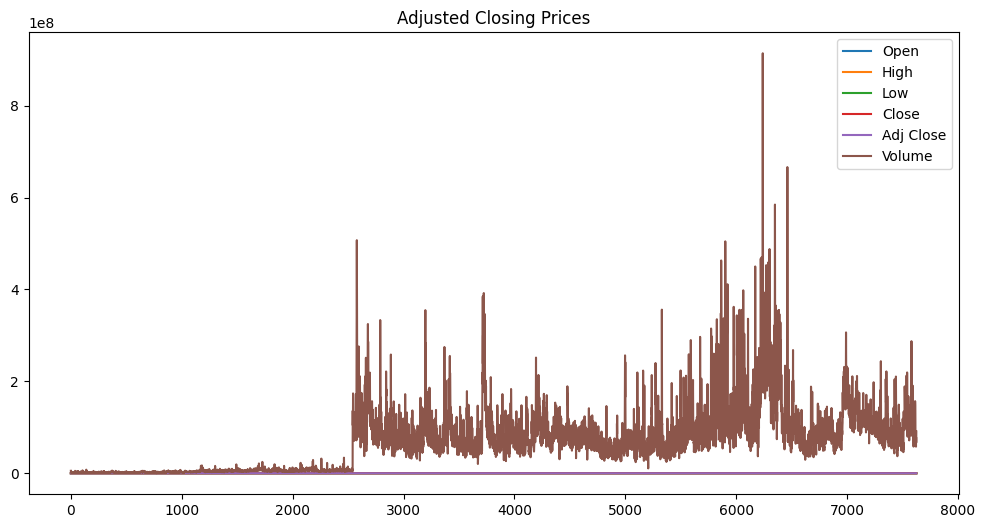

In [44]:
# Visualize closing prices
df.plot(figsize=(12, 6))
plt.title('Adjusted Closing Prices')
plt.show()

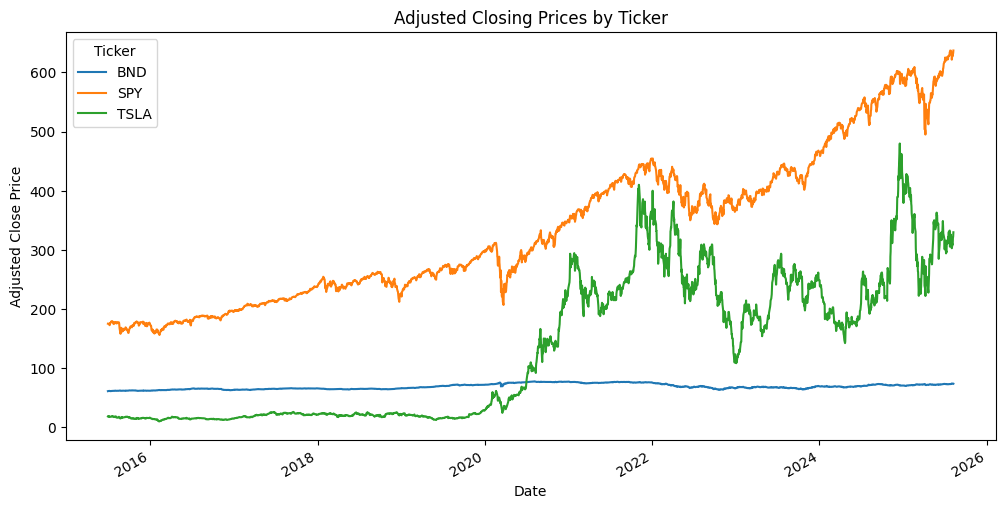

In [21]:
import matplotlib.pyplot as plt

# Pivot the DataFrame: rows=Date, columns=tickers, values=Adj Close
pivot_df = final_df.pivot(index='Date', columns='tickers', values='Adj Close')

# Plot Adjusted Closing Prices by ticker
pivot_df.plot(figsize=(12, 6))
plt.title('Adjusted Closing Prices by Ticker')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend(title='Ticker')
plt.show()

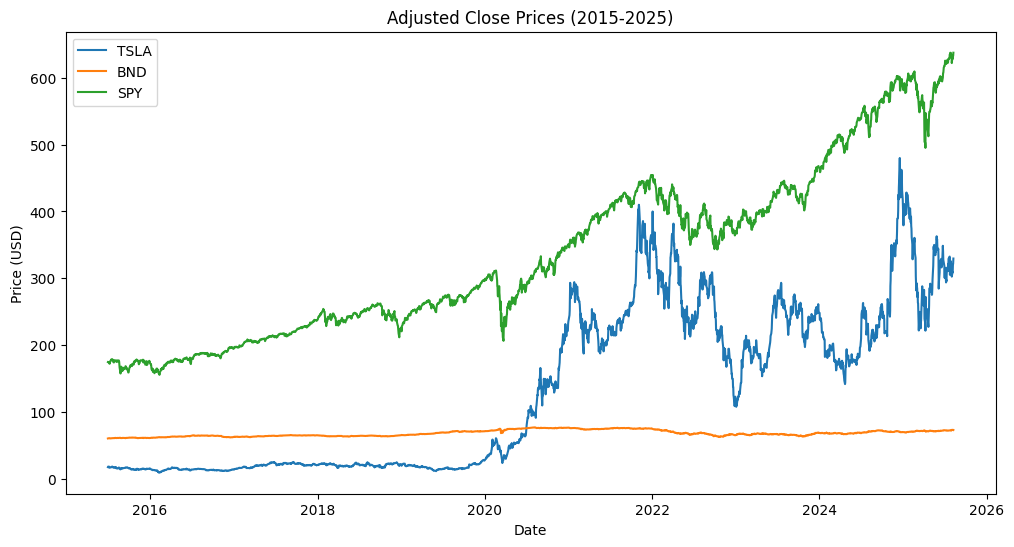

In [22]:
plt.figure(figsize=(12, 6))
for ticker in tickers:
    df_ticker = final_df[final_df['tickers'] == ticker]
    plt.plot(df_ticker['Date'], df_ticker['Adj Close'], label=ticker)
plt.title('Adjusted Close Prices (2015-2025)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [54]:
# Calculate Z-scores
df['z_score'] = (df['Close'] - df['Close'].mean()) / df['Close'].std()
# Identify outliers
z_outliers = df[np.abs(df['z_score']) > 3]
print("Outliers detected using Z-score:")
print(z_outliers[['Date', 'Close', 'z_score']])
# Calculate Q1 and Q3
Q1 = df['Close'].quantile(0.25)
Q3 = df['Close'].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
iqr_outliers = df[(df['Close'] < (Q1 - 1.5 * IQR)) | (df['Close'] > (Q3 + 1.5 * IQR))]
print("Outliers detected using IQR:")
print(iqr_outliers[['Date', 'Close']])

Outliers detected using Z-score:
Empty DataFrame
Columns: [Date, Close, z_score]
Index: []
Outliers detected using IQR:
            Date       Close
4912  2024-11-29  602.549988
4913  2024-12-02  603.630005
4914  2024-12-03  603.909973
4915  2024-12-04  607.659973
4916  2024-12-05  606.659973
...          ...         ...
5079  2025-08-04  631.169983
5080  2025-08-05  627.969971
5081  2025-08-06  632.780029
5082  2025-08-07  632.250000
5083  2025-08-08  637.179993

[71 rows x 2 columns]


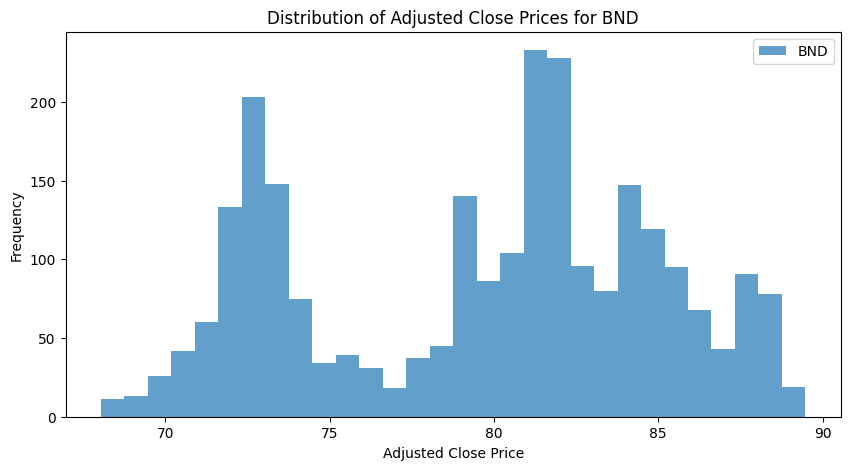

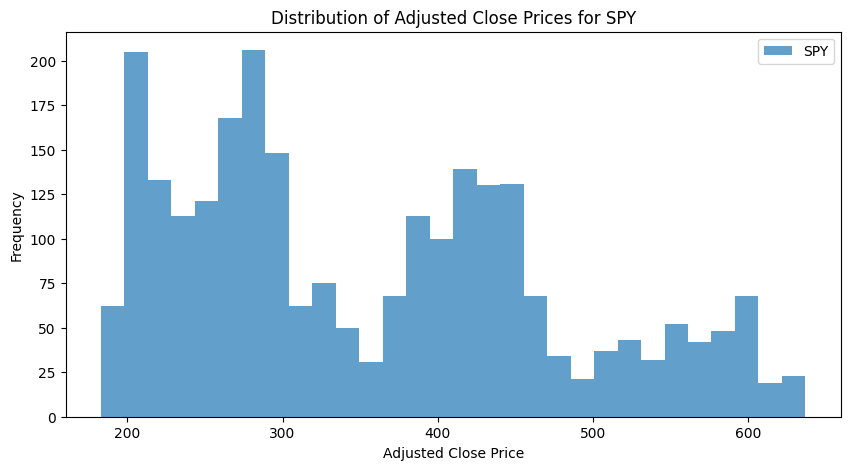

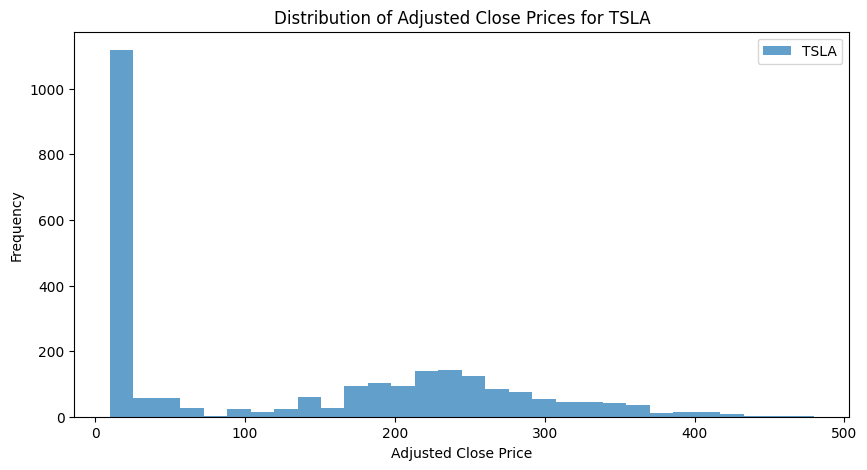

In [60]:
import matplotlib.pyplot as plt

for ticker in df['tickers'].unique():
    ticker_data = df[df['tickers'] == ticker]
    plt.figure(figsize=(10, 5))
    plt.hist(ticker_data['Close'], bins=30, alpha=0.7, label=ticker)
    plt.title(f'Distribution of Adjusted Close Prices for {ticker}')
    plt.xlabel('Adjusted Close Price')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

In [62]:
# Function to detect outliers using Z-score
def detect_outliers_z(df):
    outliers = {}
    for ticker in df['tickers'].unique():
        ticker_data = df[df['tickers'] == ticker]
        
        # Calculate Z-scores
        ticker_data['z_score'] = (ticker_data['Close'] - ticker_data['Close'].mean()) / ticker_data['Close'].std()

        # Adjusting the threshold to 2
        outliers[ticker] = ticker_data[np.abs(ticker_data['z_score']) > 2]
        
        # Print Q1, Q3, and IQR
        Q1 = ticker_data['Close'].quantile(0.25)
        Q3 = ticker_data['Close'].quantile(0.75)
        IQR = Q3 - Q1
        print(f"{ticker} - Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
        
    return outliers

# Detect outliers
z_outliers = detect_outliers_z(df)

# Display results
for ticker, outlier_data in z_outliers.items():
    print(f"Outliers detected for {ticker} using Z-score:")
    print(outlier_data[['Date', 'Adj Close', 'z_score']])

BND - Q1: 73.74499893188477, Q3: 83.94000244140625, IQR: 10.195003509521484
SPY - Q1: 258.7150115966797, Q3: 438.6175079345703, IQR: 179.90249633789062
TSLA - Q1: 18.985833644866943, Q3: 237.05999755859378, IQR: 218.07416391372684
Outliers detected for BND using Z-score:
            Date  Adj Close   z_score
2078  2023-10-03  64.077591 -2.062050
2081  2023-10-06  64.292587 -2.019239
2088  2023-10-17  64.161720 -2.045298
2089  2023-10-18  63.881302 -2.101140
2090  2023-10-19  63.600857 -2.156980
2091  2023-10-20  63.834560 -2.110445
2092  2023-10-23  64.077591 -2.062050
2093  2023-10-24  64.292587 -2.019239
2094  2023-10-25  63.806541 -2.116029
2095  2023-10-26  64.236496 -2.030407
2096  2023-10-27  64.236496 -2.030407
2097  2023-10-30  64.077591 -2.062050
2098  2023-10-31  64.058899 -2.065773
Outliers detected for SPY using Z-score:
            Date   Adj Close   z_score
4897  2024-11-07  590.087280  2.012774
4898  2024-11-08  592.643372  2.034463
4899  2024-11-11  593.208069  2.039255

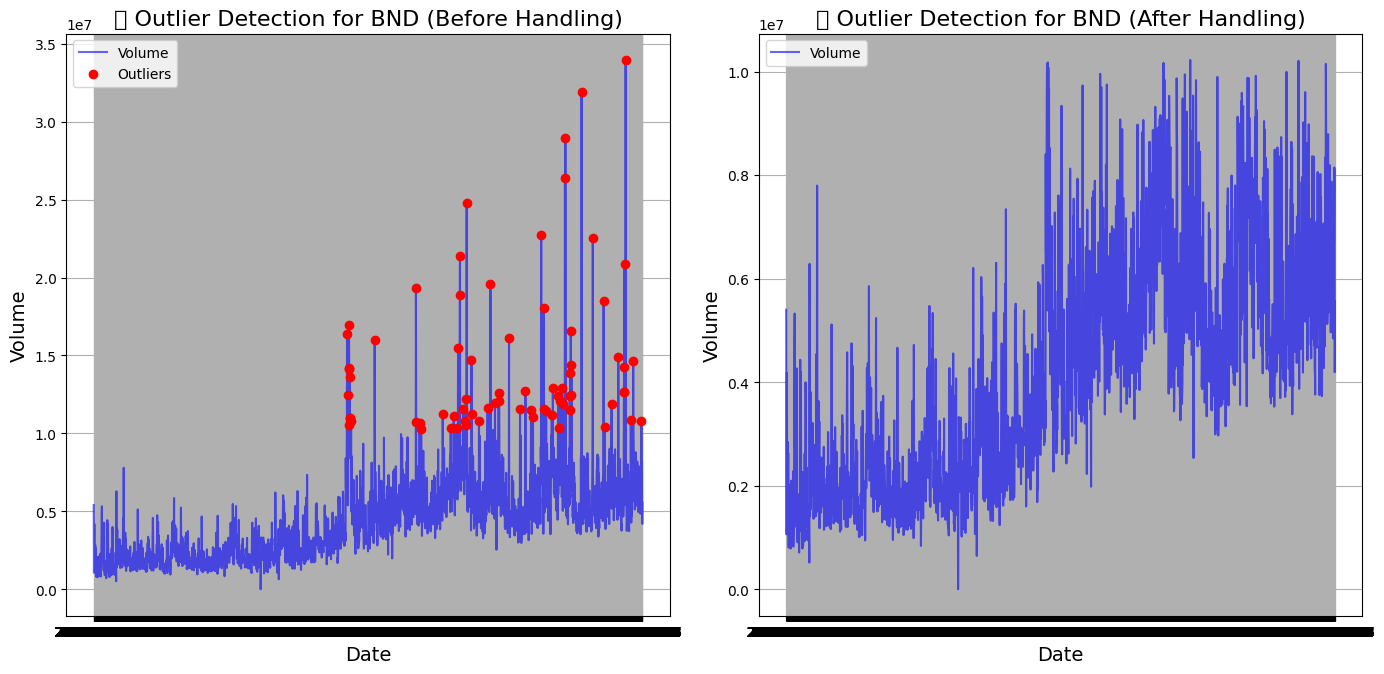

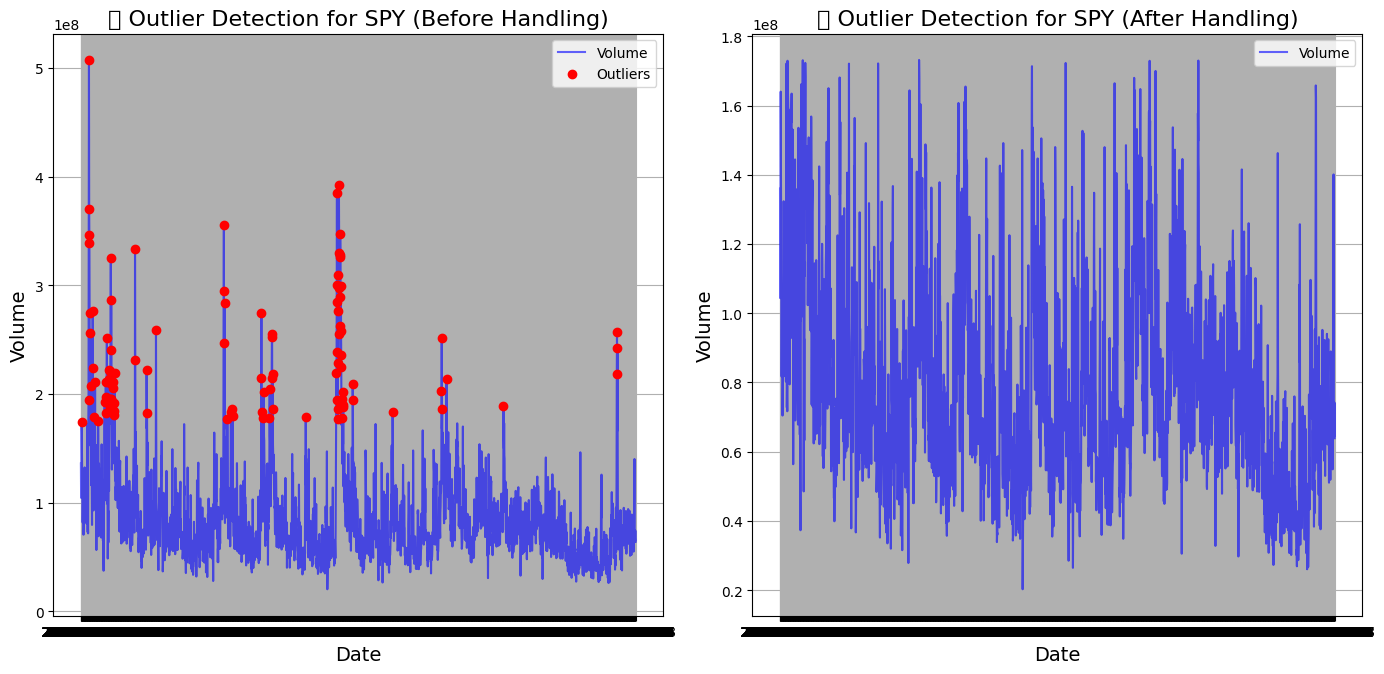

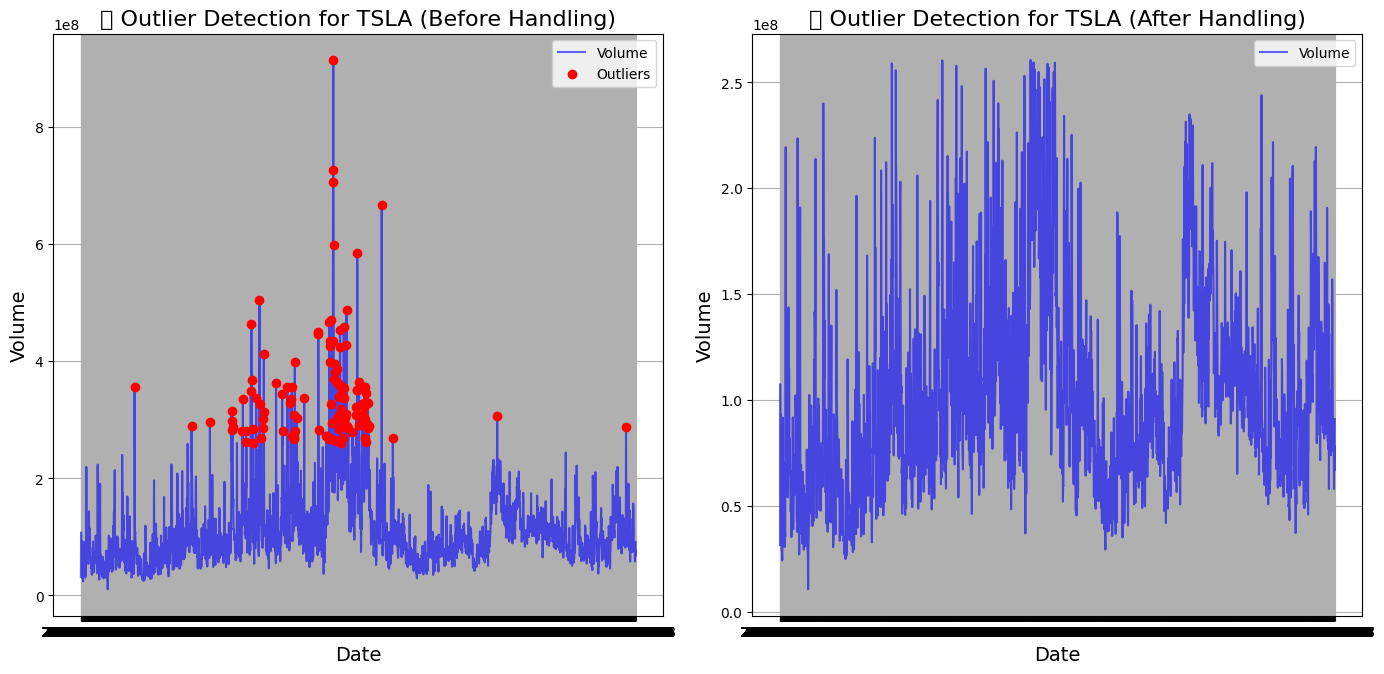

Cleaned data saved to: ../Data/cleaned_data.csv


In [82]:

# Function to detect outliers using Z-score
def detect_outliers_z(df):
    outliers = {}
    for ticker in df['tickers'].unique():
        ticker_data = df[df['tickers'] == ticker]
        ticker_data['z_score'] = (ticker_data['Volume'] - ticker_data['Volume'].mean()) / ticker_data['Volume'].std()
        outliers[ticker] = ticker_data[np.abs(ticker_data['z_score']) > 2]
    return outliers

# Function to remove outliers
def remove_outliers(df, outliers):
    for ticker in outliers.keys():
        df = df[~df.index.isin(outliers[ticker].index)]
    return df

# Function to plot outliers side by side
def plot_outliers_side_by_side(df, outliers, cleaned_df, ticker):
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))

    # Plot before handling
    axes[0].plot(df[df['tickers'] == ticker]['Date'], df[df['tickers'] == ticker]['Volume'], label='Volume', color='blue', alpha=0.6)
    if not outliers.empty:
        axes[0].scatter(outliers['Date'], outliers['Volume'], color='red', label='Outliers', zorder=5)
    axes[0].set_title(f'📊 Outlier Detection for {ticker} (Before Handling)', fontsize=16)
    axes[0].set_xlabel('Date', fontsize=14)
    axes[0].set_ylabel('Volume', fontsize=14)
    axes[0].legend()
    axes[0].grid()

    # Plot after handling
    axes[1].plot(cleaned_df[cleaned_df['tickers'] == ticker]['Date'], cleaned_df[cleaned_df['tickers'] == ticker]['Volume'], label='Volume', color='blue', alpha=0.6)
    axes[1].set_title(f'📊 Outlier Detection for {ticker} (After Handling)', fontsize=16)
    axes[1].set_xlabel('Date', fontsize=14)
    axes[1].set_ylabel('Volume', fontsize=14)
    axes[1].legend()
    axes[1].grid()

    plt.tight_layout()
    plt.show()

# Main function to detect, handle, and visualize outliers
def detect_handle_and_visualize(df):
    # Detect outliers
    z_outliers = detect_outliers_z(df)

    # Handle outliers
    cleaned_df = remove_outliers(df.copy(), z_outliers)

    # Visualize before and after handling for each ticker
    for ticker in df['tickers'].unique():
        plot_outliers_side_by_side(df, z_outliers.get(ticker, pd.DataFrame()), cleaned_df, ticker)

    # Save the cleaned DataFrame to a CSV file
    cleaned_data_path = '../Data/cleaned_data.csv'  # Adjust the path as needed
    cleaned_df.to_csv(cleaned_data_path, index=False)
    print(f"Cleaned data saved to: {cleaned_data_path}")

# Call the main function for all tickers
detect_handle_and_visualize(df)

# Steps for Exploratory Data Analysis (EDA)

Data Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7327 entries, 0 to 7326
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       7327 non-null   datetime64[ns]
 1   Open       7327 non-null   float64       
 2   High       7327 non-null   float64       
 3   Low        7327 non-null   float64       
 4   Close      7327 non-null   float64       
 5   Adj Close  7327 non-null   float64       
 6   Volume     7327 non-null   int64         
 7   tickers    7327 non-null   object        
 8   z_score    7327 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 515.3+ KB
None

Descriptive Statistics:
                                Date         Open         High          Low  \
count                           7327  7327.000000  7327.000000  7327.000000   
mean   2020-07-23 12:13:15.960147200   191.821713   193.463875   190.063112   
min          

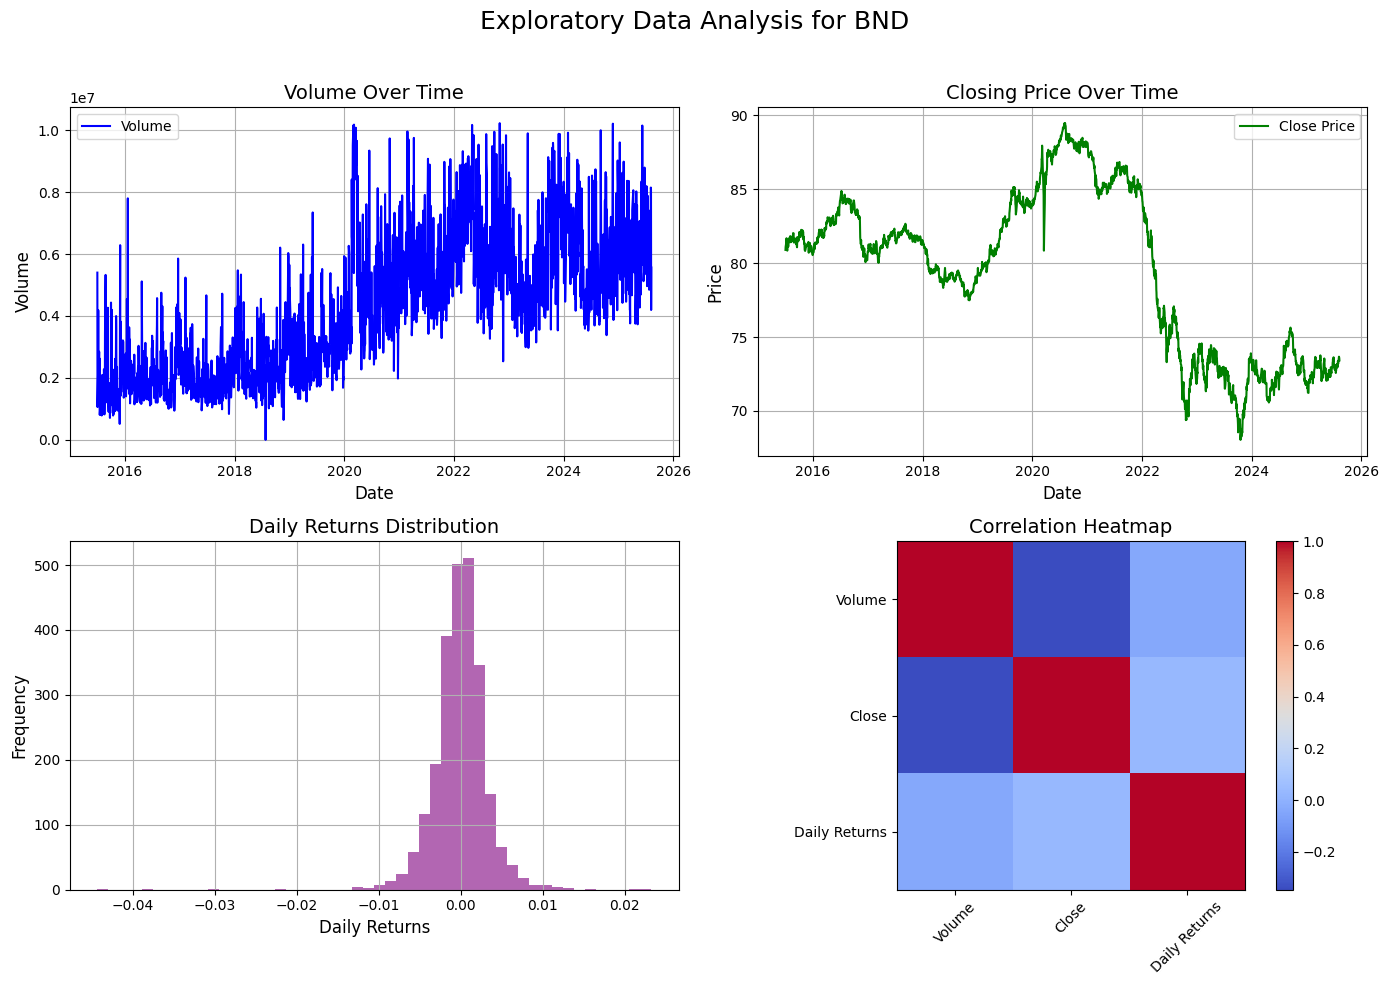

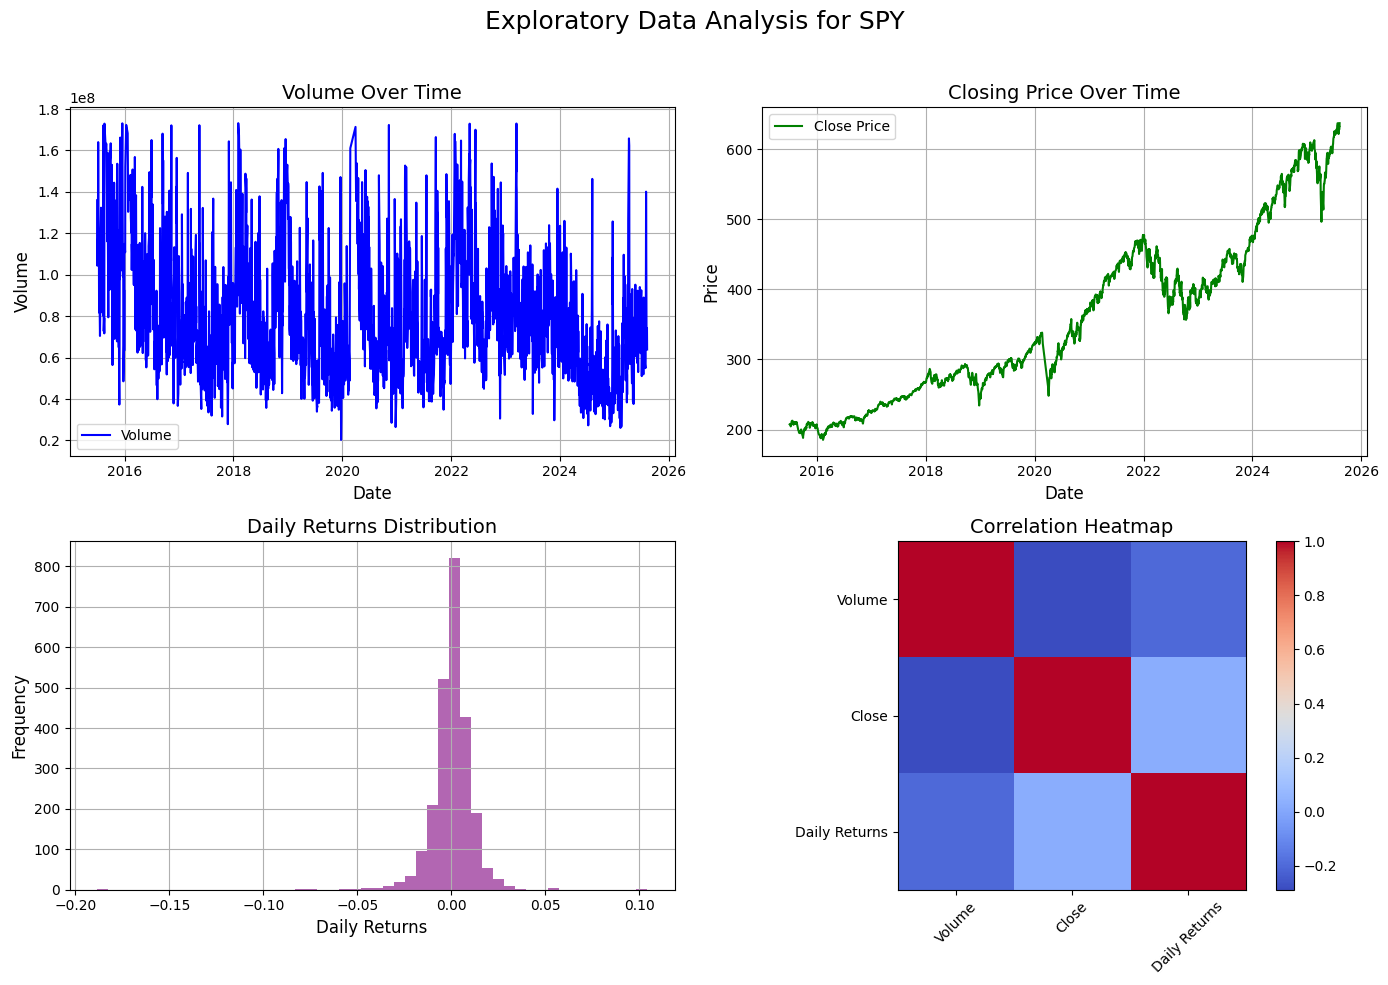

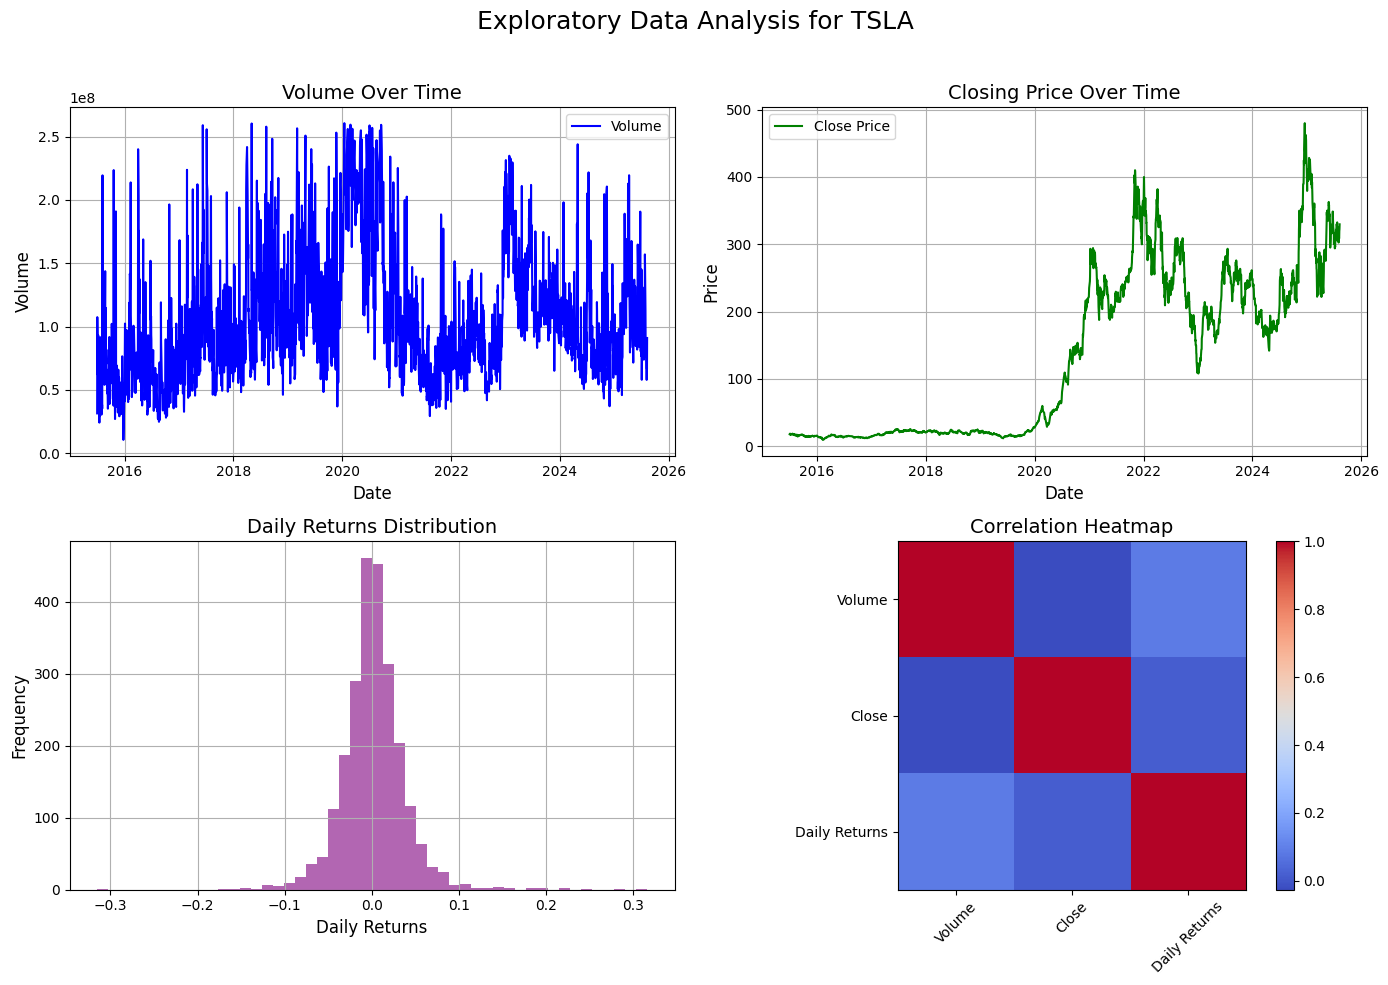

In [85]:
# Load the cleaned data
cleaned_df = pd.read_csv('cleaned_data.csv', parse_dates=['Date'])  # Adjust the path as needed

# Basic Data Overview
def basic_overview(df):
    print("Data Summary:")
    print(df.info())
    print("\nDescriptive Statistics:")
    print(df.describe())
    print("\nUnique Tickers:")
    print(df['tickers'].unique())

# Visualizations for EDA
def visualize_data(df):
    for ticker in df['tickers'].unique():
        ticker_data = df[df['tickers'] == ticker]

        # Create a figure with subplots
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle(f'Exploratory Data Analysis for {ticker}', fontsize=18)

        # Plotting Volume over Time
        axes[0, 0].plot(ticker_data['Date'], ticker_data['Volume'], label='Volume', color='blue')
        axes[0, 0].set_title('Volume Over Time', fontsize=14)
        axes[0, 0].set_xlabel('Date', fontsize=12)
        axes[0, 0].set_ylabel('Volume', fontsize=12)
        axes[0, 0].legend()
        axes[0, 0].grid()

        # Plotting Closing Price (if available)
        if 'Close' in ticker_data.columns:
            axes[0, 1].plot(ticker_data['Date'], ticker_data['Close'], label='Close Price', color='green')
            axes[0, 1].set_title('Closing Price Over Time', fontsize=14)
            axes[0, 1].set_xlabel('Date', fontsize=12)
            axes[0, 1].set_ylabel('Price', fontsize=12)
            axes[0, 1].legend()
            axes[0, 1].grid()

            # Daily Returns Calculation
            ticker_data['Daily Returns'] = ticker_data['Close'].pct_change()
            axes[1, 0].hist(ticker_data['Daily Returns'].dropna(), bins=50, color='purple', alpha=0.6)
            axes[1, 0].set_title('Daily Returns Distribution', fontsize=14)
            axes[1, 0].set_xlabel('Daily Returns', fontsize=12)
            axes[1, 0].set_ylabel('Frequency', fontsize=12)
            axes[1, 0].grid()

            # Correlation Heatmap
            correlation = ticker_data[['Volume', 'Close', 'Daily Returns']].corr()
            cax = axes[1, 1].imshow(correlation, cmap='coolwarm', interpolation='nearest')
            plt.colorbar(cax, ax=axes[1, 1])
            axes[1, 1].set_xticks(np.arange(len(correlation.columns)))
            axes[1, 1].set_yticks(np.arange(len(correlation.columns)))
            axes[1, 1].set_xticklabels(correlation.columns, rotation=45, fontsize=10)
            axes[1, 1].set_yticklabels(correlation.columns, fontsize=10)
            axes[1, 1].set_title('Correlation Heatmap', fontsize=14)

        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
        plt.show()

# Main function to execute EDA
def perform_eda(df):
    basic_overview(df)
    visualize_data(df)

# Call the EDA function
perform_eda(cleaned_df)

In [87]:

# Load the cleaned data
cleaned_df = pd.read_csv('cleaned_data.csv', parse_dates=['Date'])  # Adjust the path as needed
# Visualizations for EDA
def visualize_data(df):
    # Create the images directory if it doesn't exist
    output_dir = '../images'
    os.makedirs(output_dir, exist_ok=True)

    for ticker in df['tickers'].unique():
        ticker_data = df[df['tickers'] == ticker]

        # Create a figure with subplots
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle(f'Exploratory Data Analysis for {ticker}', fontsize=18)

        # Plotting Volume over Time
        axes[0, 0].plot(ticker_data['Date'], ticker_data['Volume'], label='Volume', color='blue')
        axes[0, 0].set_title('Volume Over Time', fontsize=14)
        axes[0, 0].set_xlabel('Date', fontsize=12)
        axes[0, 0].set_ylabel('Volume', fontsize=12)
        axes[0, 0].legend()
        axes[0, 0].grid()

        # Plotting Closing Price (if available)
        if 'Close' in ticker_data.columns:
            axes[0, 1].plot(ticker_data['Date'], ticker_data['Close'], label='Close Price', color='green')
            axes[0, 1].set_title('Closing Price Over Time', fontsize=14)
            axes[0, 1].set_xlabel('Date', fontsize=12)
            axes[0, 1].set_ylabel('Price', fontsize=12)
            axes[0, 1].legend()
            axes[0, 1].grid()

            # Daily Returns Calculation
            ticker_data['Daily Returns'] = ticker_data['Close'].pct_change()
            axes[1, 0].hist(ticker_data['Daily Returns'].dropna(), bins=50, color='purple', alpha=0.6)
            axes[1, 0].set_title('Daily Returns Distribution', fontsize=14)
            axes[1, 0].set_xlabel('Daily Returns', fontsize=12)
            axes[1, 0].set_ylabel('Frequency', fontsize=12)
            axes[1, 0].grid()

            # Correlation Heatmap
            correlation = ticker_data[['Volume', 'Close', 'Daily Returns']].corr()
            cax = axes[1, 1].imshow(correlation, cmap='coolwarm', interpolation='nearest')
            plt.colorbar(cax, ax=axes[1, 1])
            axes[1, 1].set_xticks(np.arange(len(correlation.columns)))
            axes[1, 1].set_yticks(np.arange(len(correlation.columns)))
            axes[1, 1].set_xticklabels(correlation.columns, rotation=45, fontsize=10)
            axes[1, 1].set_yticklabels(correlation.columns, fontsize=10)
            axes[1, 1].set_title('Correlation Heatmap', fontsize=14)

        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
        
        # Save the figure to the specified path
        plt.savefig(os.path.join(output_dir, f'{ticker}.png'), bbox_inches='tight')  # Save as ticker.png
        plt.close()  # Close the figure to free up memory

# Main function to execute EDA
def perform_eda(df):
    visualize_data(df)

# Call the EDA function
perform_eda(cleaned_df)

📊 Starting Analysis of Price Trends... ⏳

Analyzing BND...
ADF Statistic for BND Closing Prices: -0.9756228116117693
p-value for BND Closing Prices: 0.7620511746990822
ADF Statistic for BND Daily Returns: -10.337303654095477
p-value for BND Daily Returns: 2.7425332929833985e-18

BND Closing Prices: Non-stationary
BND Daily Returns: Stationary
Value at Risk (VaR) at 95%: -0.0050
Sharpe Ratio: -0.1586


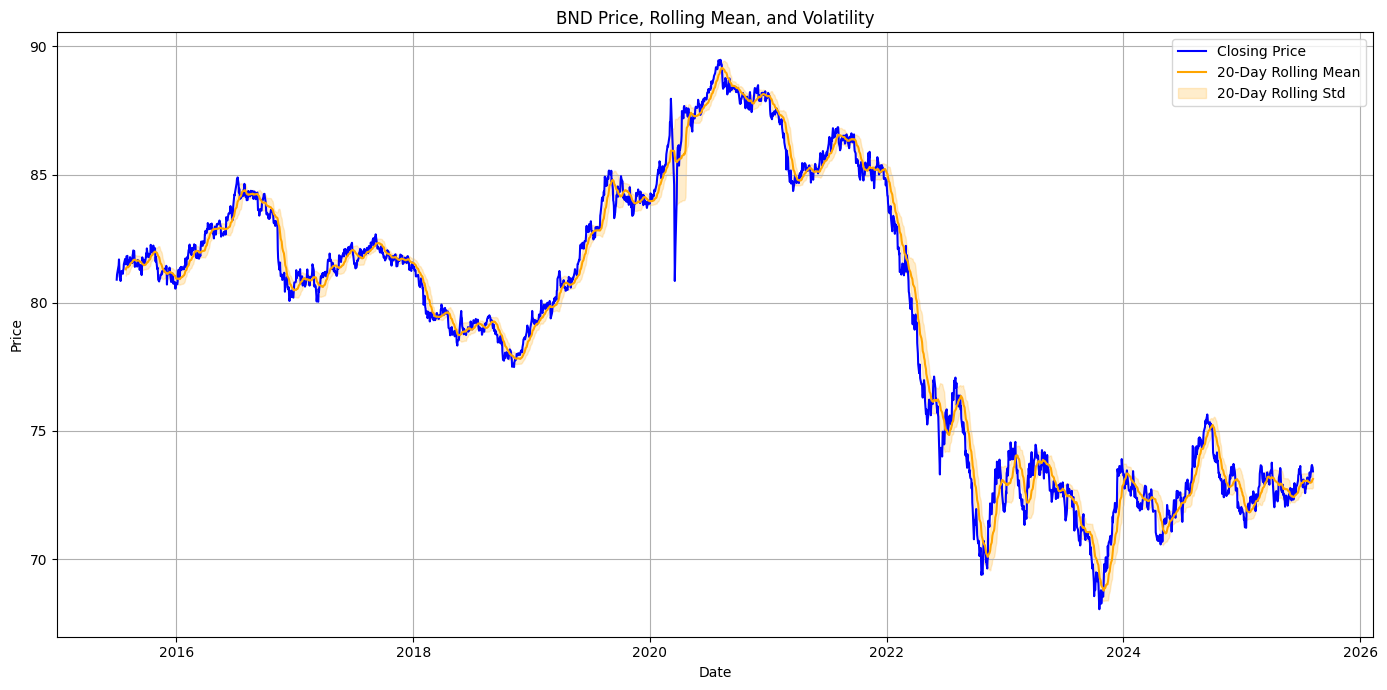


Analyzing SPY...
ADF Statistic for SPY Closing Prices: 0.6619638990033663
p-value for SPY Closing Prices: 0.9890474103958641
ADF Statistic for SPY Daily Returns: -11.219412704679605
p-value for SPY Daily Returns: 2.0310659576113144e-20

SPY Closing Prices: Non-stationary
SPY Daily Returns: Stationary
Value at Risk (VaR) at 95%: -0.0158
Sharpe Ratio: 0.7600


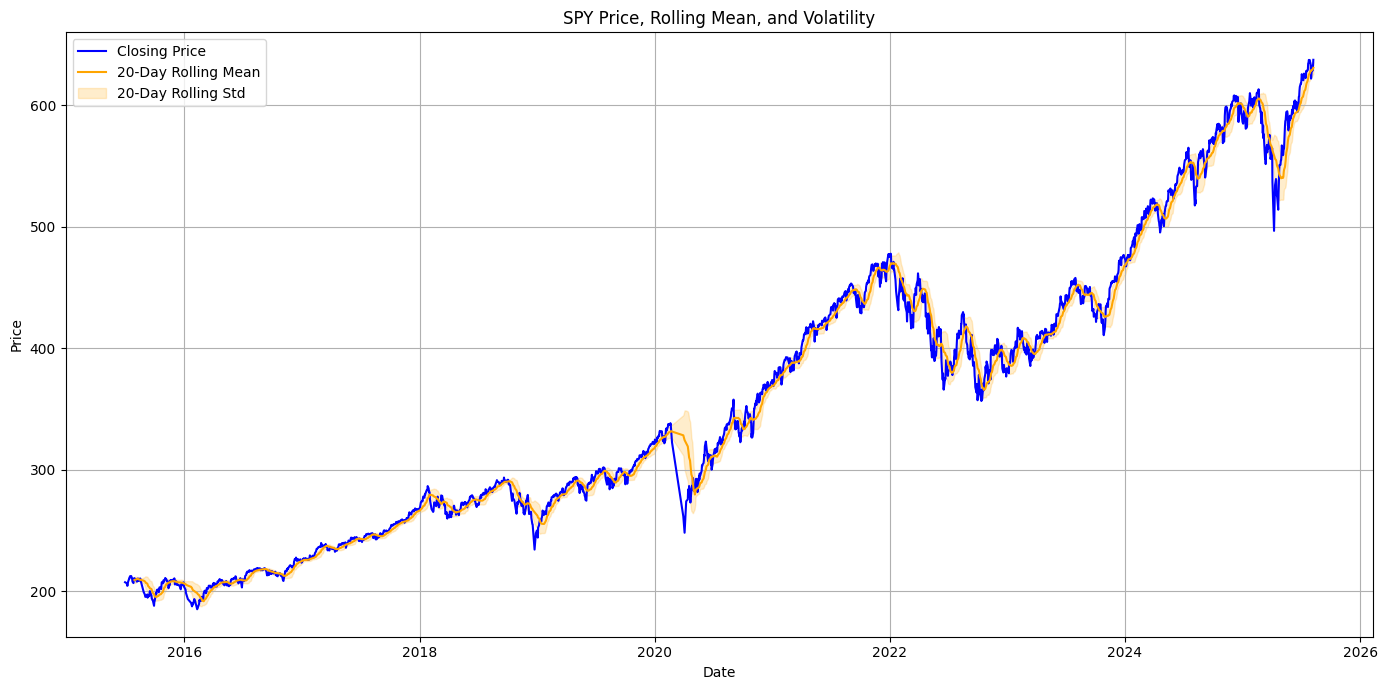


Analyzing TSLA...
ADF Statistic for TSLA Closing Prices: -1.3797190310562577
p-value for TSLA Closing Prices: 0.5919595301299588
ADF Statistic for TSLA Daily Returns: -8.918463759797008
p-value for TSLA Daily Returns: 1.0568759539779073e-14

TSLA Closing Prices: Non-stationary
TSLA Daily Returns: Stationary
Value at Risk (VaR) at 95%: -0.0512
Sharpe Ratio: 0.8053


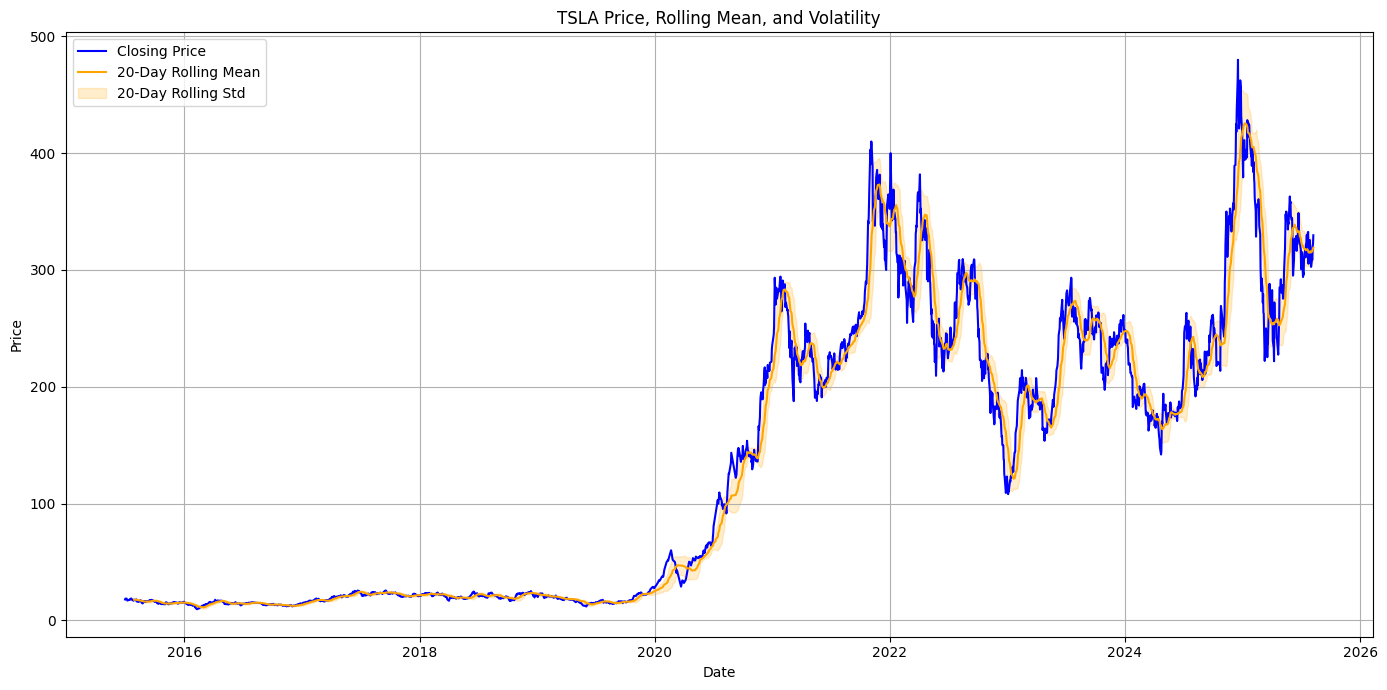

✅ Price Trend Analysis Completed Successfully! 🎉


In [89]:
# Load the cleaned data
cleaned_df = pd.read_csv('cleaned_data.csv', parse_dates=['Date'])  # Adjust the path as needed

# Create a dictionary to hold data for each ticker
data_dict = {ticker: cleaned_df[cleaned_df['tickers'] == ticker] for ticker in cleaned_df['tickers'].unique()}

# Function to perform the analysis
def analyze_price_trend(data_dict):
    for ticker, df in data_dict.items():
        print(f"\nAnalyzing {ticker}...")

        # Calculate Daily Returns
        df['Daily Returns'] = df['Close'].pct_change()

        # Augmented Dickey-Fuller Test
        adf_result_price = adfuller(df['Close'].dropna())
        adf_result_returns = adfuller(df['Daily Returns'].dropna())
        
        print(f"ADF Statistic for {ticker} Closing Prices: {adf_result_price[0]}")
        print(f"p-value for {ticker} Closing Prices: {adf_result_price[1]}")
        print(f"ADF Statistic for {ticker} Daily Returns: {adf_result_returns[0]}")
        print(f"p-value for {ticker} Daily Returns: {adf_result_returns[1]}\n")

        # Interpret the results
        if adf_result_price[1] > 0.05:
            print(f"{ticker} Closing Prices: Non-stationary")
        else:
            print(f"{ticker} Closing Prices: Stationary")

        if adf_result_returns[1] > 0.05:
            print(f"{ticker} Daily Returns: Non-stationary")
        else:
            print(f"{ticker} Daily Returns: Stationary")

        # Calculate Rolling Mean and Volatility
        df['Rolling Mean'] = df['Close'].rolling(window=20).mean()
        df['Rolling Std'] = df['Close'].rolling(window=20).std()

        # Calculate Value at Risk (VaR) and Sharpe Ratio
        VaR_95 = np.percentile(df['Daily Returns'].dropna(), 5)
        mean_return = df['Daily Returns'].mean()
        std_return = df['Daily Returns'].std()
        sharpe_ratio = mean_return / std_return * np.sqrt(252)  # Annualized Sharpe Ratio

        print(f"Value at Risk (VaR) at 95%: {VaR_95:.4f}")
        print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

        # Plotting
        plt.figure(figsize=(14, 7))
        plt.plot(df['Date'], df['Close'], label='Closing Price', color='blue')
        plt.plot(df['Date'], df['Rolling Mean'], label='20-Day Rolling Mean', color='orange')
        plt.fill_between(df['Date'], df['Rolling Mean'] - df['Rolling Std'], 
                         df['Rolling Mean'] + df['Rolling Std'], color='orange', alpha=0.2, label='20-Day Rolling Std')
        plt.title(f'{ticker} Price, Rolling Mean, and Volatility')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.savefig(f'../images/{ticker}_price_trend.png')  # Save the plot
        plt.show()

# Run the analysis
print("📊 Starting Analysis of Price Trends... ⏳")
analyze_price_trend(data_dict)
print("✅ Price Trend Analysis Completed Successfully! 🎉")

In [ ]:

# Create a dictionary to hold data for each ticker
data_dict = {ticker: cleaned_df[cleaned_df['tickers'] == ticker] for ticker in cleaned_df['tickers'].unique()}

# Function to perform the analysis
def analyze_price_trend(data_dict):
    for ticker, df in data_dict.items():
        print(f"\nAnalyzing {ticker}...")

        # Calculate Daily Returns
        df['Daily Returns'] = df['Close'].pct_change()

        # Augmented Dickey-Fuller Test
        adf_result_price = adfuller(df['Close'].dropna())
        adf_result_returns = adfuller(df['Daily Returns'].dropna())
        
        print(f"ADF Statistic for {ticker} Closing Prices: {adf_result_price[0]}")
        print(f"p-value for {ticker} Closing Prices: {adf_result_price[1]}")
        print(f"ADF Statistic for {ticker} Daily Returns: {adf_result_returns[0]}")
        print(f"p-value for {ticker} Daily Returns: {adf_result_returns[1]}\n")

        # Interpret the results
        if adf_result_price[1] > 0.05:
            print(f"{ticker} Closing Prices: Non-stationary")
        else:
            print(f"{ticker} Closing Prices: Stationary")

        if adf_result_returns[1] > 0.05:
            print(f"{ticker} Daily Returns: Non-stationary")
        else:
            print(f"{ticker} Daily Returns: Stationary")

        # Calculate Rolling Mean and Volatility
        df['Rolling Mean'] = df['Close'].rolling(window=20).mean()
        df['Rolling Std'] = df['Close'].rolling(window=20).std()

        # Calculate Value at Risk (VaR) and Sharpe Ratio
        VaR_95 = np.percentile(df['Daily Returns'].dropna(), 5)
        mean_return = df['Daily Returns'].mean()
        std_return = df['Daily Returns'].std()
        sharpe_ratio = mean_return / std_return * np.sqrt(252)  # Annualized Sharpe Ratio

        print(f"Value at Risk (VaR) at 95%: {VaR_95:.4f}")
        print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

        # Plotting
        plt.figure(figsize=(14, 7))
        plt.plot(df['Date'], df['Close'], label='Closing Price', color='blue')
        plt.plot(df['Date'], df['Rolling Mean'], label='20-Day Rolling Mean', color='orange')
        plt.fill_between(df['Date'], df['Rolling Mean'] - df['Rolling Std'], 
                         df['Rolling Mean'] + df['Rolling Std'], color='orange', alpha=0.2, label='20-Day Rolling Std')
        plt.title(f'{ticker} Price, Rolling Mean, and Volatility')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.savefig(f'../images/{ticker}_price_trend.png')  # Save the plot
        plt.close()  # Close the figure to free up memory

# Run the analysis
print("📊 Starting Analysis of Price Trends... ⏳")
analyze_price_trend(data_dict)
print("✅ Price Trend Analysis Completed Successfully! 🎉")

📊 Starting Analysis of Price Trends... ⏳

Analyzing BND...
ADF Statistic for BND Closing Prices: -0.9756228116117693
p-value for BND Closing Prices: 0.7620511746990822
ADF Statistic for BND Daily Returns: -10.337303654095477
p-value for BND Daily Returns: 2.7425332929833985e-18

BND Closing Prices: Non-stationary
BND Daily Returns: Stationary
Value at Risk (VaR) at 95%: -0.0050
Sharpe Ratio: -0.1586

Analyzing SPY...
ADF Statistic for SPY Closing Prices: 0.6619638990033663
p-value for SPY Closing Prices: 0.9890474103958641
ADF Statistic for SPY Daily Returns: -11.219412704679605
p-value for SPY Daily Returns: 2.0310659576113144e-20

SPY Closing Prices: Non-stationary
SPY Daily Returns: Stationary
Value at Risk (VaR) at 95%: -0.0158
Sharpe Ratio: 0.7600

Analyzing TSLA...
ADF Statistic for TSLA Closing Prices: -1.3797190310562577
p-value for TSLA Closing Prices: 0.5919595301299588
ADF Statistic for TSLA Daily Returns: -8.918463759797008
p-value for TSLA Daily Returns: 1.0568759539779073

In [ ]:
# Task 2: Develop_Time_Series_Forecasting_Models

# Prepare TSLA data for forecasting
tsla_prices = data['TSLA'].dropna()
train_size = int(len(tsla_prices) * 0.8)  # 80% train, 20% test
train, test = tsla_prices[:train_size], tsla_prices[train_size:]

# ARIMA Model
# Use auto_arima to find optimal (p, d, q)
arima_model = auto_arima(train, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
arima_fit = arima_model.fit(train)
arima_forecast = arima_fit.predict(n_periods=len(test))

# LSTM Model
# Prepare data for LSTM
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(tsla_prices.values.reshape(-1, 1))

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)
X_train, y_train = X[:train_size - seq_length], y[:train_size - seq_length]
X_test, y_test = X[train_size - seq_length:], y[train_size - seq_length:]

# Build LSTM model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Forecast with LSTM
lstm_forecast = lstm_model.predict(X_test)
lstm_forecast = scaler.inverse_transform(lstm_forecast)

# Evaluate models
def evaluate_forecast(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mae, rmse, mape

arima_mae, arima_rmse, arima_mape = evaluate_forecast(test, arima_forecast)
lstm_mae, lstm_rmse, lstm_mape = evaluate_forecast(test[-len(lstm_forecast):], lstm_forecast.flatten())

print(f"ARIMA: MAE={arima_mae:.2f}, RMSE={arima_rmse:.2f}, MAPE={arima_mape:.2f}%")
print(f"LSTM: MAE={lstm_mae:.2f}, RMSE={lstm_rmse:.2f}, MAPE={lstm_mape:.2f}%")

In [ ]:
# Task 3: Forecast_Future_Market_Trends

# Forecast 12 months ahead using the better model (assuming LSTM performs better)
future_steps = 252  # Approx. 1 year of trading days
last_sequence = scaled_data[-seq_length:].reshape(1, seq_length, 1)
future_forecast = []
for _ in range(future_steps):
    pred = lstm_model.predict(last_sequence)
    future_forecast.append(pred[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = pred[0, 0]
future_forecast = scaler.inverse_transform(np.array(future_forecast).reshape(-1, 1))

# Simulate confidence intervals (using bootstrap method for simplicity)
bootstrap_forecasts = []
n_bootstraps = 100
for _ in range(n_bootstraps):
    noise = np.random.normal(0, lstm_mae, future_steps)
    bootstrap_forecasts.append(future_forecast.flatten() + noise)
ci_lower = np.percentile(bootstrap_forecasts, 2.5, axis=0)
ci_upper = np.percentile(bootstrap_forecasts, 97.5, axis=0)

# Plot forecast with confidence intervals
future_dates = pd.date_range(start=tsla_prices.index[-1] + pd.Timedelta(days=1), periods=future_steps, freq='B')
plt.figure(figsize=(12, 6))
plt.plot(tsla_prices.index, tsla_prices, label='Historical TSLA')
plt.plot(future_dates, future_forecast, label='Forecast', color='red')
plt.fill_between(future_dates, ci_lower, ci_upper, color='red', alpha=0.2, label='95% CI')
plt.title('TSLA Price Forecast (12 Months)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [ ]:
# Task 4: Optimize Portfolio Based on Forecast

# Calculate expected returns
tsla_forecast_returns = np.mean(np.diff(future_forecast.flatten()) / future_forecast[:-1].flatten()) * 252
bnd_hist_returns = expected_returns.mean_historical_return(data['BND']) * 252
spy_hist_returns = expected_returns.mean_historical_return(data['SPY']) * 252
exp_returns = np.array([tsla_forecast_returns, bnd_hist_returns, spy_hist_returns])

# Calculate covariance matrix
cov_matrix = risk_models.sample_cov(daily_returns) * 252

# Portfolio optimization
ef = EfficientFrontier(exp_returns, cov_matrix)
weights_max_sharpe = ef.max_sharpe()
max_sharpe_port = ef.portfolio_performance(verbose=True)
weights_min_vol = ef.min_volatility()
min_vol_port = ef.portfolio_performance(verbose=True)

# Plot Efficient Frontier
ef = EfficientFrontier(exp_returns, cov_matrix)
fig, ax = plt.subplots(figsize=(10, 6))
ef.plot_efficient_frontier(ax=ax)
plt.scatter(max_sharpe_port[1], max_sharpe_port[0], marker='*', s=200, color='r', label='Max Sharpe')
plt.scatter(min_vol_port[1], min_vol_port[0], marker='o', s=200, color='g', label='Min Volatility')
plt.title('Efficient Frontier')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.legend()
plt.show()

# Recommend Max Sharpe portfolio
print("Recommended Portfolio (Max Sharpe):")
print("Weights:", weights_max_sharpe)
print("Expected Return:", max_sharpe_port[0])
print("Volatility:", max_sharpe_port[1])
print("Sharpe Ratio:", max_sharpe_port[2])


In [ ]:
# Task 5: Strategy_Backtesting

# Backtesting period: Last year
backtest_data = data['2024-08-01':'2025-07-31']
backtest_returns = backtest_data.pct_change().dropna()

# Portfolio returns with optimized weights
portfolio_returns = (backtest_returns * pd.Series(weights_max_sharpe)).sum(axis=1)

# Benchmark: 60% SPY, 40% BND
benchmark_weights = {'SPY': 0.6, 'BND': 0.4, 'TSLA': 0.0}
benchmark_returns = (backtest_returns * pd.Series(benchmark_weights)).sum(axis=1)

# Cumulative returns
portfolio_cum_returns = (1 + portfolio_returns).cumprod()
benchmark_cum_returns = (1 + benchmark_returns).cumprod()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(portfolio_cum_returns, label='Optimized Portfolio')
plt.plot(benchmark_cum_returns, label='Benchmark (60% SPY, 40% BND)')
plt.title('Portfolio vs Benchmark Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

# Performance metrics
portfolio_sharpe = (portfolio_returns.mean() * 252) / (portfolio_returns.std() * np.sqrt(252))
benchmark_sharpe = (benchmark_returns.mean() * 252) / (benchmark_returns.std() * np.sqrt(252))
portfolio_total_return = portfolio_cum_returns.iloc[-1] - 1
benchmark_total_return = benchmark_cum_returns.iloc[-1] - 1

print(f"Portfolio Total Return: {portfolio_total_return:.2%}")
print(f"Benchmark Total Return: {benchmark_total_return:.2%}")
print(f"Portfolio Sharpe Ratio: {portfolio_sharpe:.2f}")
print(f"Benchmark Sharpe Ratio: {benchmark_sharpe:.2f}")

In [ ]:
# Import necessary libraries
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
#import seaborn as sns  
import os  
import sys

sys.path.append(os.path.abspath(os.path.join('..', 'scripts')))
from data_preprocessing import DataPreprocessor 
processor = DataPreprocessor()
start_date = "2015-01-01"  # Start date = January-01-2015
end_date = "2025-01-31"    # End date = January-31-2025
symbols = ["BND", "SPY", "TSLA"]  # Bond, S&P 500, and Tesla stocks
for symbol, path in data_paths.items():
    print(f"{symbol}: {path}")



ModuleNotFoundError: No module named 'data_preprocessing'

In [8]:
df= pd.read_csv('../Data/SPY_data.csv')
df

,Date,SPY
0,2015-07-01,174.917099
1,2015-07-02,174.756943
2,2015-07-06,174.259598
3,2015-07-07,175.355453
4,2015-07-08,172.413467
...,...,...
2535,2025-07-31,632.080017
2536,2025-08-01,621.719971
2537,2025-08-04,631.169983
2538,2025-08-05,627.969971
